
Attaching package: 'readr'

The following objects are masked from 'package:scales':

    col_factor, col_numeric



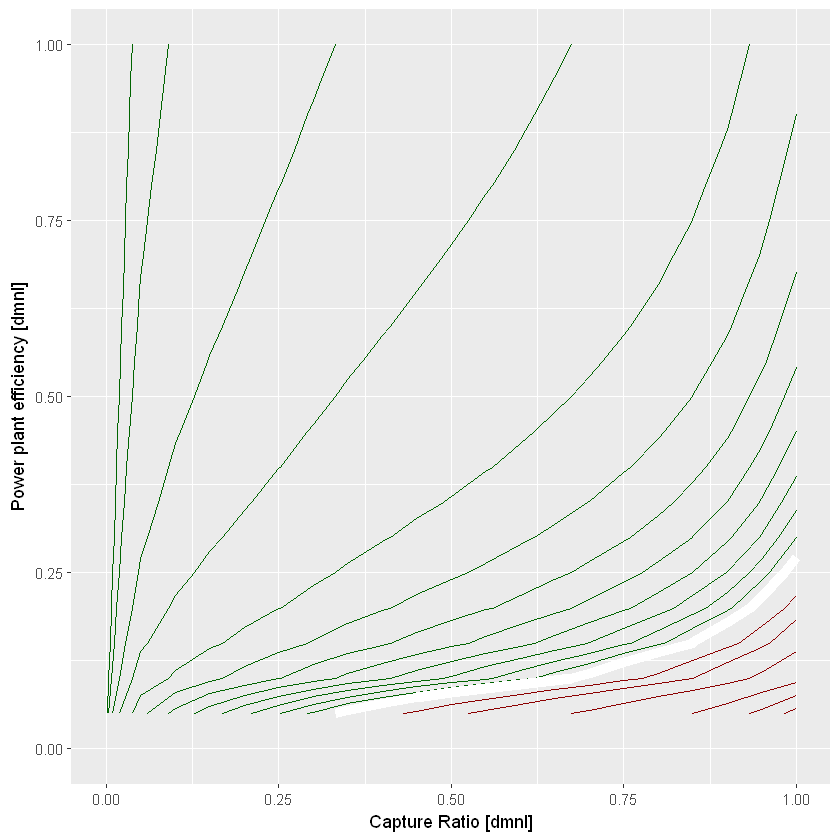

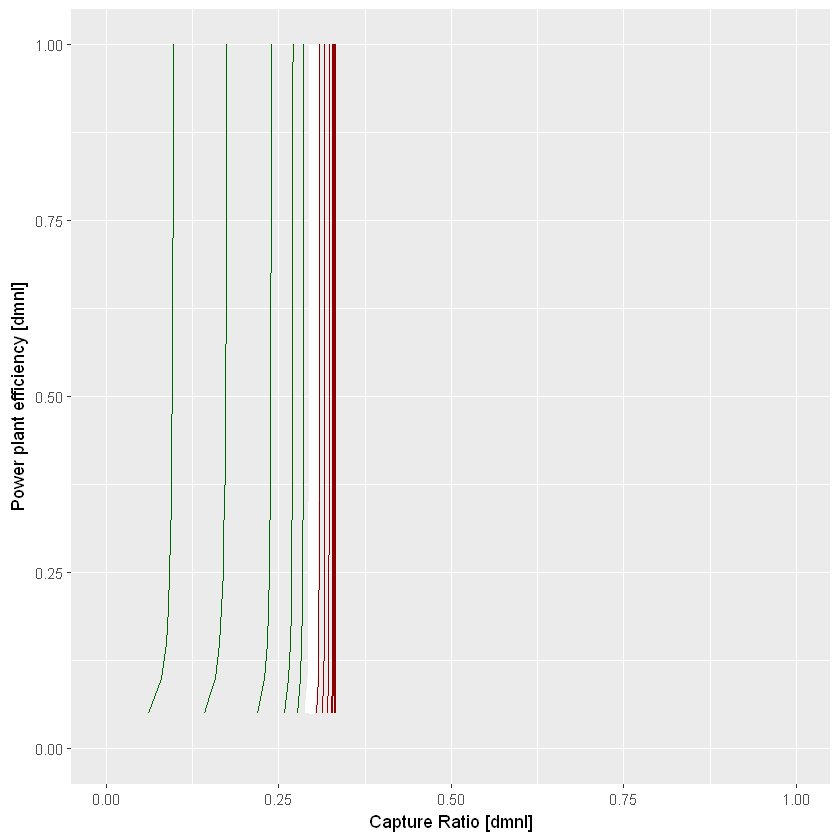

In [1]:
#this script plots EROI curves for CCS technologies
#library(sfsmisc)
#library(gplots)
library(lattice)
library(graphics)
#library(igraphs)
library(ggplot2)
library(RColorBrewer)
library(reshape2)
library("scales")
library(readr)

#set working directory
setwd('/')

##### define parameter arrays ######
#capture rate (CR), 
#efficiency (eta), 
#ratio of power plant to CCS construction energy (r_PP_CCS), and  
#ratio of CCS construction to operation energy (r) as arrays

CR_array <- c(seq(0.00,1.0,0.05)) #c(0.01:0.99), units [dmnl]
eta_array <- c(seq(0.05,1,0.05)) #c(0.01:0.99), [dmnl]
r_PP_CCS_array <- c(seq(0.05,2.0,0.05)) #c(0.01:2.00) [dmnl]
r_array <- c(seq(0.1,10,0.1)) #c(0.01:10) [dmnl]

##### define variable arrays #####
# b is fraction of electricity used for CCS [kWh/kWh = dmnl]
# EROI_1 is EROI where CCS construction energy is a ratio of power plant construction energy [MJ_e/MW/(MJ_p/MW) = dmnl]
# EROI_1_adj makes adjustment for electrical output [MJ_p/MJ_p = dmnl]
# EROI_2 is EROI where CCS cons. energy is a ratio of CCS operation energy [MJ_e/MJ_p = dmnl]
# EROI_2_adj makes adjustment for electrical output [MJ_p/MJ_p = dmnl]
# E is emissions [kg CO2/kWh]

b <- array(dim = c(length(CR_array), length(eta_array)),
           dimnames = list(CR_array, eta_array))
CCS_op <- array(dim = c(length(CR_array)),
                    dimnames = list(CR_array))
Elec_CO2 <- array(dim = c(length(eta_array)),
                  dimnames = list(eta_array))
EROI_1 <- array(dim=c(length(CR_array), length(eta_array), length(r_PP_CCS_array)),
              dimnames=list(CR_array, eta_array, r_PP_CCS_array)) #EROI using r_PP_CCS, units [dmnl]
EROI_1_adj <- array(dim=c(length(CR_array), length(eta_array), length(r_PP_CCS_array)),
                dimnames=list(CR_array, eta_array, r_PP_CCS_array)) 
EROI_2 <- array(dim=c(length(CR_array), length(eta_array), length(r_array)),
                dimnames=list(CR_array, eta_array, r_array)) #EROI using r, units [dmnl]
EROI_2_adj <- array(dim=c(length(CR_array), length(eta_array), length(r_array)),
                dimnames=list(CR_array, eta_array, r_array))
E <- array(dim=c(length(CR_array), length(eta_array)),
             dimnames=list(CR_array, eta_array)) #Emissions, units [kg CO2/kWh]

##### Define parameters #####
PP_L <- 30 #power plant lifetime [yrs]
PP_CF <- 0.5 #power plant capacity factor [dmnl]
CCS_L <- 30 #CCS plant lifetime [yrs]

C_CO2 <- 0.088 #carbon dioxide content of coal [kg/MJ]

PP_cons_energy <- 40000 #energy cost of power plant construction [MJ/MW], does not include energy embodied in materials

##### loop through calculations #####
for (i in (1:length(CR_array))) {
  for (j in (1:length(eta_array))) {
    for(k in (1:length(r_PP_CCS_array))) {
      for(l in (1:length(r_array))) {
    
    #Define electricity penalty (b) curve from Sanpasternich (2009) Figure 8, units [kWh/kg CO2] 
    CCS_op[i] <- 25.957*CR_array[i]^6 - 85.031*CR_array[i]^5 + 114.5*CR_array[i]^4 - 80.385*CR_array[i]^3 + 31.47*CR_array[i]^2 - 6.7725*CR_array[i]  + 1.1137 
    
    PP_op <- 0.01 #operational cost of coal fuel cycle [MJ/MJ coal = dmnl]
    PP_op_L <- 1*8760*PP_L*PP_CF*PP_op/eta_array[j] #operational cost of coal fuel cycle over plant lifetime output [kWh]
    
    #define carbon intensity of electricity, units [kg CO2/kWh]
    Elec_CO2[j] <- C_CO2*3.6/eta_array[j] 
    
    #energy penalty of CCS, units [dmnl]
    b[i,j] <- CCS_op[i]*Elec_CO2[j]*CR_array[i]
    
    #energy cost of constructing CCS plant
    CCS_cons_energy <- r_PP_CCS_array[k]*PP_cons_energy 
    
    EROI_1[i,j,k] <- 1*8760*PP_L*PP_CF*(1-b[i])*3.6/(PP_cons_energy + PP_op_L + CCS_cons_energy*PP_L/CCS_L) 
    
    EROI_1_adj[i,j,k] <- EROI_1[i,j,k]/0.3
    
    EROI_2[i,j,l] <- 1*8760*PP_L*PP_CF*(1-b[i])/(PP_cons_energy + PP_op_L + r_array[l]*CCS_op[i])
    
    EROI_2_adj[i,j,l] <- EROI_2[i,j,l]/0.3
    
    E[i,j] <- Elec_CO2[j]*(1-CR_array[i])
      
      }
    }
  }
}

#### melt arrays into dataframe ####
b_m <- melt(b)
names(b_m) <- c("CR", "ETA", "b")

EROI_1m <- melt(EROI_1)
names(EROI_1m) <- c("CR", "ETA", "r_PP_CCS", "EROI_1")

EROI_1m_adj <- melt(EROI_1_adj)
names(EROI_1m_adj) <- c("CR", "ETA", "r_PP_CCS", "EROI_1_adj")

EROI_2m <- melt(EROI_2)
names(EROI_2m) <- c("CR", "ETA", "r", "EROI_2")

EROI_2m_adj <- melt(EROI_2_adj)
names(EROI_2m_adj) <- c("CR", "ETA", "r", "EROI_2_adj")

E_m <- melt(E)
names(E_m) <- c("CR", "ETA", "E")

#### merge data ####

EROI_1 <- merge(EROI_1m, EROI_1m_adj, by = c("CR", "ETA", "r_PP_CCS"))
EROI_2 <- merge(EROI_2m, EROI_2m_adj, by = c("CR", "ETA", "r"))

#write_csv(EROI_1, path = "CR_eta_EROI_1.csv")
#write_csv(EROI_2, path = "CR_eta_EROI_2.csv")

#### plot b as function of CR and ETA ##########################
breaks_b_p <- c(0.01,0.02,0.05,0.1,0.2,0.3, 0.4,0.5,0.6, 0.7,0.8,0.9)
breaks_b_0 <- c(1)
breaks_b_n <- c(1.25,1.5,2,3,4,5,6,7,8,9)
#labels <- c("fractional re-investment = 20 %","30 %","40 %","50 %","60 %","70 %","80 %","90 %","100 %", "125 %","150 %","175 %","200 %","250 %","300 %","350 %","400 %","500 %", "750 %","1000 %")
y_axis <- c(seq(0,1,0.1))
x_axis <- c(seq(0,1,0.1))

#establish 1st plot - contours
##------------log axis ---------------##
f <- ggplot(data=b_m, aes(x=CR, y=ETA, z=b))
f + stat_contour(colour ="dark green", breaks=breaks_b_p) +
  stat_contour(colour ="white", breaks=breaks_b_0, size=3) +
  stat_contour(colour ="dark red", breaks=breaks_b_n) +
  ylab("Power plant efficiency [dmnl]") +
  xlab("Capture Ratio [dmnl]") +
  xlim(0,1) +
  ylim(0,1)
#geom_point()

#### plot EROI as function of CR and ETA ##########################
breaks_p <- c(1.5,2,3,5,7.5,15,25,50,100,200,500)
breaks_0 <- c(1)
breaks_n <- c(0.015,0.05,0.1,0.15,0.3,0.5,0.75)
#labels <- c("fractional re-investment = 20 %","30 %","40 %","50 %","60 %","70 %","80 %","90 %","100 %", "125 %","150 %","175 %","200 %","250 %","300 %","350 %","400 %","500 %", "750 %","1000 %")
y_axis <- c(seq(0,1,0.1))
x_axis <- c(seq(0,1,0.1))

#establish 1st plot - contours
##------------log axis ---------------##
f <- ggplot(data=subset(EROI_1, r_PP_CCS == 2, select = c(CR, ETA, EROI_1_adj)), aes(x=CR, y=ETA, z=EROI_1_adj))
f + stat_contour(colour ="dark green", breaks=breaks_p) +
  stat_contour(colour ="white", breaks=breaks_0, size=3) +
  stat_contour(colour ="dark red", breaks=breaks_n) +
  ylab("Power plant efficiency [dmnl]") +
  xlab("Capture Ratio [dmnl]") +
  xlim(0,1) +
  ylim(0,1)
  #geom_point()